# **TP3 - Problema 2**

### **Grupo 23**

Pedro Gonçalves a101250
<br>
José Loureiro a96467
<br>
Bruno Neiva a95311


Relativo ao programa do problema 1 anterior,

É pedido construir um “Control Flow Automaton (CFA)” que determina este programa, identificando os locais e as transições/ramos, numa abordagem orientada às pré-condições identificando os transformadores de predicados associados aos vários locais e os “switches” associados aos vários ramos. 

Importações necessárias para executar o nosso código

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import INT
import networkx as nx
import matplotlib.pyplot as plt

A) Criação do grafo com nodos e as suas respetivas ligações

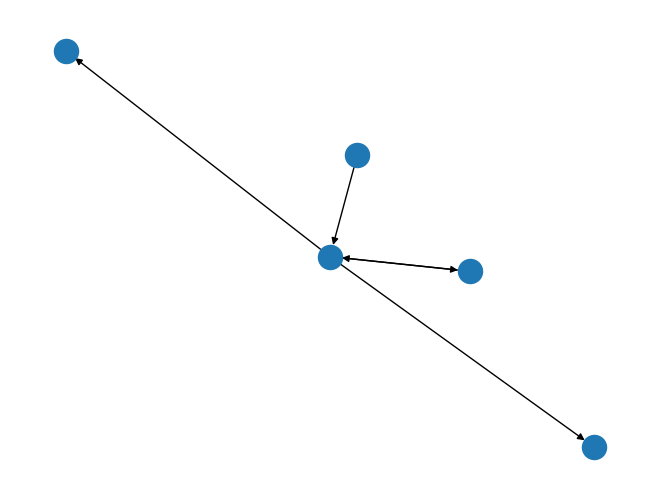

In [2]:
G = nx.DiGraph()

A = Symbol("A", INT)    
B = Symbol("B", INT) 
R1 = Symbol("R1", INT)                    # R
R2 = Symbol("R2", INT)                    # R'

# Nodes: label-annotation tuples.
nodes = [("Init", "A e B > 0"),           # Iniciar variaveis
         ("Skip",""),                     # Skip
         ("Do", "R2 != 0"),               # Função while r' != 0
         ("Stop", "R2 = 0"),              # Estado de paragem do ciclo while R = 0
         ("Error", "R1 = 0")]             # Estado de erro

# Edges: source-target-condition tuples.
edges = [("Init", "Skip", (And(GT(A, Int(0))),(GT(B, Int(0))))),      # ligação init ao skip com a pre-condição A e B > 0
         ("Skip", "Do", (NotEquals(R2, Int(0)))),                     # condição do ciclo While
         ("Do", "Skip", ""),                                          # devolver valor ao ciclo while
         ("Skip", "Stop", (Equals(R2, Int(0)))),                      # condição em caso de paragem/stop se R2 = r' = 0
         ("Skip", "Error", (Or(Equals(R1, Int(0))), "overflow"))]     # condição em caso de erro R1 = r = 0 or overflow (2^n-1)

for label, annotation in  nodes:
    G.add_node(label, annotation = annotation)

for source, target, condition in edges:
    G.add_edge(source, target, condition = condition)

nx.draw(G)

Elaboração do Grafo respetivo ao Problema 1)

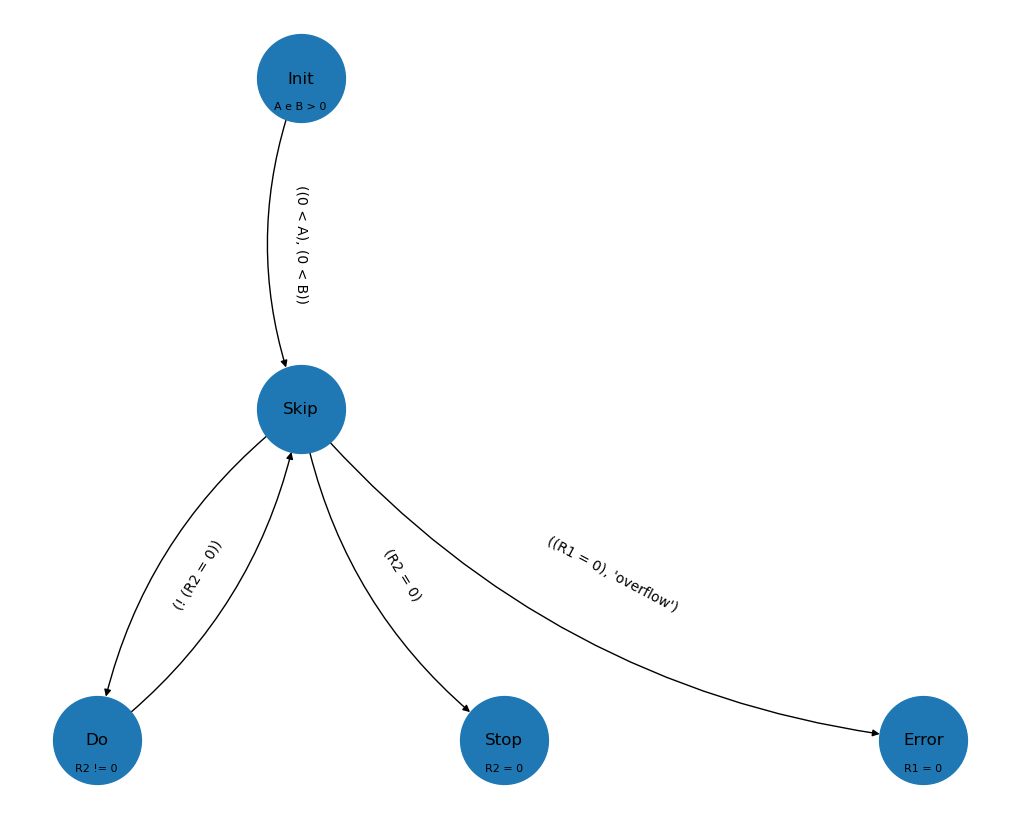

In [3]:
pos = nx.nx_pydot.pydot_layout(G, prog="dot")

plt.figure(figsize=(10, 8))

nx.draw(G, pos  = pos, with_labels = True, node_size = 4000, connectionstyle="arc3,rad=0.2")

edge_conds = nx.get_edge_attributes(G, name = "condition")
nx.draw_networkx_edge_labels(G, pos, edge_conds)

annotations = nx.get_node_attributes(G, "annotation")
for node, annotation in annotations.items():
    xp, yp = pos[node]
    plt.text(xp, yp - 5, annotation, fontsize=8, ha="center", va="top")

plt.show()

 Parte B) verifiqucação da segurança do programa com um sistema de equações baseadas nas nossas pre-condições

In [4]:
def ex1_safety(a, b, nbits, k_iteracoes):
    print(f"> A testar o caso r1 = {a} e para r2 = {b} ({k_iteracoes} tentativas).")
    with Solver() as solver:
      R1 = BV(a, nbits)
      R2 = BV(b, nbits)
      error = TRUE()
      stop = FALSE()

      do = FALSE()
      guarda = And(BVUGT(R1, BV(0,nbits)), BVUGT(R2, BV(0,nbits)))                  # pre-condições A(R1) e B(R2) > 0

      for i in range(k_iteracoes):
          print(f"Estamos na {i} iteração")
          system = And(guarda, do)
          if solver.solve([system]):
            print(f"> Iteração {i}: sistema inseguro.")
            return

          # do
          atrib = substitute(do, {R1: R2, R2: BVSub(R1, BVMul(BVUDiv(R1, R2),R2))}) # atualizar valores do ciclo while
      
        
          new_do = And(Implies(Equals(R1, BV(0, nbits)), error),                    # condição em caso de erro R1 = r = 0 or overflow (2^n-1)
                       Implies(Equals(R2, BV(0, nbits)), stop),                     # condição em caso de paragem/stop se R2 = r' = 0
                       Implies(BVUGT(R2, BV(0, nbits)), atrib))                     # condição do ciclo While
          
          do = Or(do, new_do)

      print("> Não foram encontrados estados inseguros.")


# teste de funcionalidade 
ex1_safety(48, 18, 9, 10)

> A testar o caso r1 = 48 e para r2 = 18 (10 tentativas).
Estamos na 0 iteração
Estamos na 1 iteração
Estamos na 2 iteração
Estamos na 3 iteração
Estamos na 4 iteração
Estamos na 5 iteração
Estamos na 6 iteração
Estamos na 7 iteração
Estamos na 8 iteração
Estamos na 9 iteração
> Não foram encontrados estados inseguros.
